In [7]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import gmean


#### Callable to parse the given keyword in logfile

In [8]:
def extract_useful(log_file, keyword):
    with open(log_file, 'r') as f:
        for line in f:
            if keyword in line:  # Assuming the line with IPC contains the keyword 'IPC'
                _value = float(re.search(r"\s([\d\.]+)", line).group(1))
                return _value
    return None

### Parsing the Prefetch useful metric for each class from each trace log

In [9]:
groups = ['450.soplex-247B', '462.libquantum-714B', '471.omnetpp-188B', '482.sphinx3-234B', '602.gcc_s-2226B', '623.xalancbmk_s-10B']
classes = ["stream:pref_useful:", "CS:pref_filled:", "CPLX:pref_useful:", "ISB:pref_useful:", "NL:pref_useful:"]
data = {group:{c:None for c in classes} for group in groups}

for key in data.keys():
    log_file = "../logs/SPEC-CPU/v3/" + key + "-ipcp_isb-V3-train_on_miss-pf_on_all.log"
    for item in classes:
        data[key][item] = extract_useful(log_file, item)

for group in data.keys():
    acc = 0
    for item in classes:
        acc = acc + data[group][item]
    for item in classes:
        data[group][item] = 100*data[group][item]/acc

### Plot showing per class contribution in V3 combined prefetcher

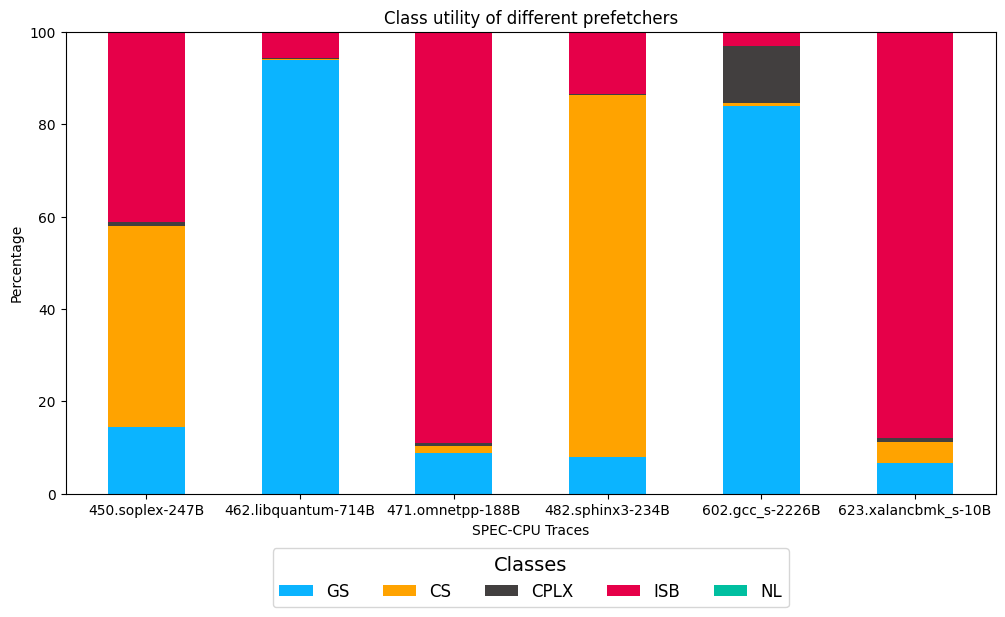

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data
groups = ['450.soplex-247B', '462.libquantum-714B', '471.omnetpp-188B', '482.sphinx3-234B', '602.gcc_s-2226B', '623.xalancbmk_s-10B']
factors = {
    'GS':   [14.54, 93.95, 8.78, 7.94, 83.84, 6.60],
    'CS':   [43.49, 0.20, 1.66, 78.28, 0.66, 4.62],
    'CPLX': [0.7, 0.10, 0.55, 0.32, 12.53, 0.77],
    'ISB':  [41.22, 5.75, 88.97, 13.46, 2.97, 87.98],
    'NL':   [0.05, 0.0, 0.04, 0.0, 0.0, 0.03]
}

# Normalize data to sum up to 100% for each group
data = np.array(list(factors.values()))
normalized_data = data / data.sum(axis=0) * 100

# Bar positions
x = np.arange(len(groups))
width = 0.5  # Width of each bar

# Colors for the factors
colors = ['#0bb4ff', '#ffa300', '#423f3f', '#e60049', '#00bfa0']
plt.figure(figsize=(12, 6))
# Plot each factor on top of the previous ones
cumulative = np.zeros(len(groups))
for idx, (factor, color) in enumerate(zip(factors.keys(), colors)):
    plt.bar(x, normalized_data[idx], width, bottom=cumulative, label=factor, color=color)
    cumulative += normalized_data[idx]

# Labels and legend
plt.xticks(x, groups)
plt.xlabel('SPEC-CPU Traces')
plt.ylabel('Percentage')
plt.title('Class utility of different prefetchers')
# Horizontal legend
plt.legend(
    title='Classes', 
    fontsize=12, 
    title_fontsize=14, 
    ncol=5,  # Number of columns in the legend
    loc='upper center',  # Place the legend at the top-center
    bbox_to_anchor=(0.5, -0.1)  # Adjust position: (x, y)
)
# Show plot
plt.show()


In [11]:
base_dir = "../logs/SPEC-CPU/v3/"
# Define trace names and configuration labels
trace_names = [ '450.soplex-247B', '462.libquantum-714B', 
'471.omnetpp-188B', '482.sphinx3-234B','602.gcc_s-2226B', '623.xalancbmk_s-10B']
configs = ['baseline', 'ipcp', 'ipcp_isb-V3-train_on_miss-pf_on_all', 'isb']

# Initialize a dictionary to store IPC values for each trace and configuration
ipc_values = {trace: {} for trace in trace_names}


In [12]:
ipc_values

{'450.soplex-247B': {},
 '462.libquantum-714B': {},
 '471.omnetpp-188B': {},
 '482.sphinx3-234B': {},
 '602.gcc_s-2226B': {},
 '623.xalancbmk_s-10B': {}}

In [13]:
def extract_ipc(log_file):
    with open(log_file, 'r') as f:
        for line in f:
            if 'CPU 0 cumulative IPC' in line:  # Assuming the line with IPC contains the keyword 'IPC'
                ipc_value = float(re.search(r"IPC:\s([\d\.]+)", line).group(1))
                return ipc_value
    return None

# Parse the IPC values from the log files
for trace in trace_names:
    for config in configs:
        log_file = base_dir + f"{trace}-{config}.log"
        ipc_values[trace][config] = extract_ipc(log_file)


In [14]:
# Calculate speedups relative to the baseline
speedups = {trace: {} for trace in trace_names}

for trace in trace_names:
    baseline_ipc = ipc_values[trace]['baseline']
    for config in configs[1:]:  # Skip baseline
        speedups[trace][config] = ipc_values[trace][config] / baseline_ipc
# Calculate geometric mean for each configuration (excluding baseline)
geomeans = {}
for config in configs[1:]:
    config_speedups = [speedups[trace][config] for trace in trace_names]
    geomeans[config] = gmean(config_speedups)  # Use scipy's gmean for geometric mean

speedups['Geomean'] = geomeans
trace_names += ['Geomean']

In [15]:
speedups

{'450.soplex-247B': {'ipcp': 1.3543471720818292,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 1.6284972924187726,
  'isb': 1.4130678399518652},
 '462.libquantum-714B': {'ipcp': 1.4574295591519566,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 1.4529391569193326,
  'isb': 1.4245418667971979},
 '471.omnetpp-188B': {'ipcp': 1.0313069383303854,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 1.3936951674180864,
  'isb': 1.3000802400996574},
 '482.sphinx3-234B': {'ipcp': 1.482130433935978,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 1.531240097787392,
  'isb': 1.4092466086858002},
 '602.gcc_s-2226B': {'ipcp': 3.882139626616738,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 3.933669249776413,
  'isb': 2.654300780847664},
 '623.xalancbmk_s-10B': {'ipcp': 1.1042213761879034,
  'ipcp_isb-V3-train_on_miss-pf_on_all': 1.4799946389904548,
  'isb': 1.2326845674126008},
 'Geomean': {'ipcp': np.float64(1.5320979830355521),
  'ipcp_isb-V3-train_on_miss-pf_on_all': np.float64(1.7567795064766805),
  'isb': np.float64(1.5144894

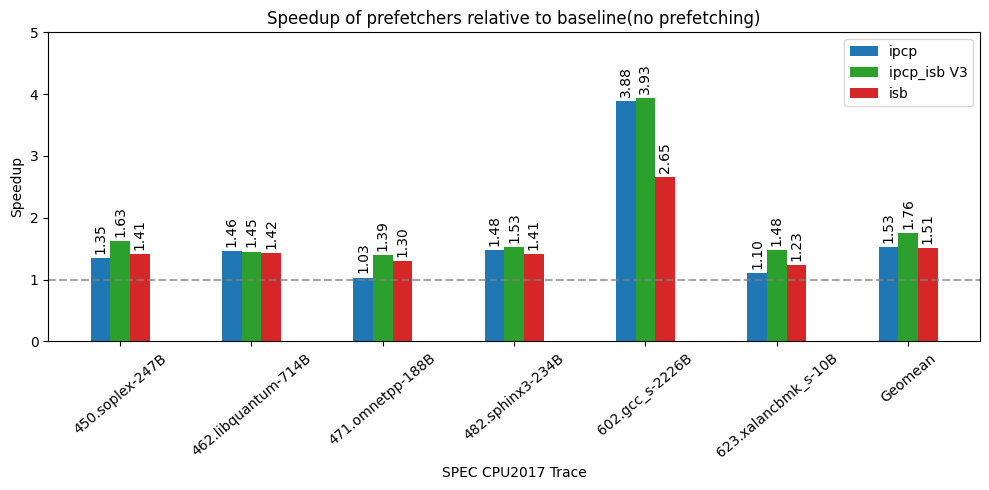

In [16]:
# Plotting the speedups
plt.rcParams.update({'font.size': 10})
x = np.arange(len(trace_names))  # X axis positions for the traces
width = 0.15  # Width of the bars
colors = ["tab:blue", "tab:green", "tab:red"]
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars for each configuration
for i, config in enumerate(configs[1:]):  # Skip baseline
    speedup_values = [speedups[trace][config] for trace in trace_names]
    bars = ax.bar(x + i*width, speedup_values, width, label=config, color=colors[i])
    
    # Annotate bars with speedup values
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',  # Format the annotation to 2 decimal places
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text slightly above the bar
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Add a translucent dashed line at y=1.0 for the baseline
ax.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)


# Add labels and titles
ax.set_xlabel('SPEC CPU2017 Trace')
ax.set_ylim(0, 5.0)
ax.set_ylabel('Speedup')
ax.set_title('Speedup of prefetchers relative to baseline(no prefetching)')
ax.set_xticks(x + 2*width / 2)
ax.set_xticklabels(trace_names, rotation=40)
# Retrieve existing handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Update the labels
plt.legend(handles, ['ipcp', 'ipcp_isb V3', 'isb'])

# Show the plot
plt.tight_layout()
plt.show()
